In [ ]:
import cv2
import tensorflow as tf
import keras
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Activation
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

In [ ]:
from google.colab import drive
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
parasitized_data = os.listdir("/content/drive/MyDrive/neiron lab/lab2/cell_images/Parasitized")
uninfected_data = os.listdir("/content/drive/MyDrive/neiron lab/lab2/cell_images/Uninfected")
print(parasitized_data[:10])
print(uninfected_data[:10])

['C116P77ThinF_IMG_20150930_171844_cell_127.png', 'C116P77ThinF_IMG_20150930_171844_cell_113.png', 'C116P77ThinF_IMG_20150930_171809_cell_75.png', 'C116P77ThinF_IMG_20150930_171954_cell_102.png', 'C116P77ThinF_IMG_20150930_171844_cell_87.png', 'C116P77ThinF_IMG_20150930_171954_cell_113.png', 'C116P77ThinF_IMG_20150930_171844_cell_88.png', 'C116P77ThinF_IMG_20150930_171954_cell_107.png', 'C116P77ThinF_IMG_20150930_171954_cell_114.png', 'C116P77ThinF_IMG_20150930_171954_cell_77.png']
['C115P76ThinF_IMG_20150930_161825_cell_126.png', 'C115P76ThinF_IMG_20150930_162038_cell_62.png', 'C115P76ThinF_IMG_20150930_162315_cell_105.png', 'C115P76ThinF_IMG_20150930_161825_cell_2.png', 'C115P76ThinF_IMG_20150930_162038_cell_15.png', 'C115P76ThinF_IMG_20150930_162038_cell_167.png', 'C115P76ThinF_IMG_20150930_162038_cell_25.png', 'C115P76ThinF_IMG_20150930_161825_cell_25.png', 'C115P76ThinF_IMG_20150930_162038_cell_156.png', 'C115P76ThinF_IMG_20150930_161825_cell_128.png']


In [ ]:
def show_img(path, img_data, count, title_name):
  plt.figure(figsize = (12, 12))
  for i in range(6):
    plt.subplot(1, 6, i+1)
    img = cv2.imread(path + img_data[i + count])
    plt.imshow(img)
    plt.title(title_name)
    plt.tight_layout
  plt.show()

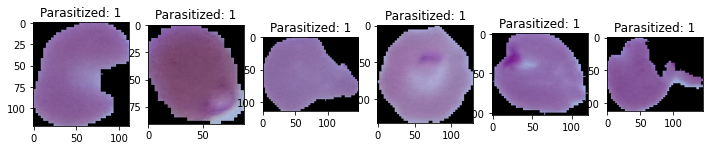

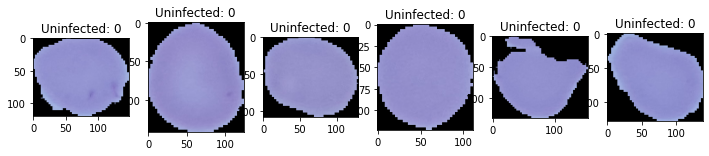

In [ ]:
show_img("/content/drive/MyDrive/neiron lab/lab2/cell_images/Parasitized/", parasitized_data, 0, "Parasitized: 1")
show_img("/content/drive/MyDrive/neiron lab/lab2/cell_images/Uninfected/", uninfected_data, 1, "Uninfected: 0")

In [ ]:
def add_img(data, labels, count, images, path, app):
  for img in images:
  if count == 2000:
    count = 0
    break
  img_read = cv2.imread(path + img, 0)
  img_resize = cv2.resize(img_read, (28, 28))
  data.append(img_resize)
  labels.append(app)
  count+=1
  if count % 100 == 0:
    print(count)
  return data, labels, count

In [ ]:
data = []
labels = []
count = 0

data, labels, count = add_img(data, labels, count, parasitized_data, "/content/drive/MyDrive/neiron lab/lab2/cell_images/Parasitized/", 0)
data, labels, count = add_img(data, labels, count, uninfected_data, "/content/drive/MyDrive/neiron lab/lab2/cell_images/Uninfected/", 1)


print(data[0])

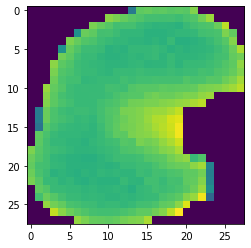

In [ ]:
plt.imshow(data[0])
plt.show()

In [ ]:
x_trn, x_tst, y_trn, y_tst = train_test_split(data, labels, test_size = 0.2, random_state = 42)

In [ ]:
x_train = np.array(x_trn, np.float32).reshape([-1, 28*28]) / 255.
x_test = np.array(x_tst, np.float32).reshape([-1, 28*28]) / 255.

y_train = tf.one_hot(y_trn, depth=2)
y_test = tf.one_hot(y_tst, depth=2)

In [ ]:
print(x_train.shape)
print(y_train[0])

(3200, 784)
tf.Tensor([1. 0.], shape=(2,), dtype=float32)


In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
lr = 0.01
epochs = 100
batch_size = 32
num_features = 28 * 28
n_hidden_1 = 1000
n_hidden_2 = 10
num_classes = 2

all_losses = []
all_accuracy = []
all_epochs = []

In [ ]:
class Model(object):
    def __init__(self):
        rnd_norm = tf.initializers.RandomNormal()
        self.W1 = tf.Variable(rnd_norm([num_features, n_hidden_1]))
        self.W2 = tf.Variable(rnd_norm([n_hidden_1, n_hidden_2]))
        self.Wout = tf.Variable(rnd_norm([n_hidden_2, num_classes]))
        self.B1 = tf.Variable(tf.zeros([n_hidden_1]))
        self.B2 = tf.Variable(tf.zeros([n_hidden_2]))
        self.Bout = tf.Variable(tf.zeros([num_classes]))


    def forward(self, x):
        self.layer1 = tf.nn.sigmoid(tf.add(tf.matmul(x, self.W1), self.B1))
        self.layer2 = tf.nn.sigmoid(tf.add(tf.matmul(self.layer1, self.W2), self.B2))
        self.output = tf.nn.softmax(tf.add(tf.matmul(self.layer2, self.Wout), self.Bout))
        return self.output

In [ ]:
def loss(y_pred, y_target):
    cross_entropy = tf.keras.losses.mean_squared_error(y_target, y_pred)
    #cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_target * tf.math.log(y_pred)))
    return max(cross_entropy)

In [ ]:
model = Model()
optimizer = tf.optimizers.Adadelta(lr)

/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
def optimization(x, y):
    with tf.GradientTape() as gt:
        cur_loss = loss(model.forward(x), y)

    trainable_variables = [model.W1, model.W2, model.Wout, model.B1, model.B2, model.Bout]
    grad = gt.gradient(cur_loss, trainable_variables)
    optimizer.apply_gradients(zip(grad, trainable_variables))

In [ ]:
def train(epochs):
    for epoch, (batch_x, batch_y) in enumerate(train_data.take(epochs), 1):
        optimization(batch_x, batch_y)
        if(epoch % 100 == 0):
            pred = model.forward(batch_x)
            loss_r = loss(pred, batch_y)
            #acc_r = accuracy(pred, batch_y)
            all_losses.append(loss_r)
            #all_accuracy.append(acc_r)
            all_epochs.append(epoch)
            print("Epoch {0} Loss is {1}".format(epoch, loss_r))

    return model

In [ ]:
model = train(1000)

Epoch 100 Loss is 0.3007296621799469
Epoch 200 Loss is 0.26071110367774963
Epoch 300 Loss is 0.25295311212539673
Epoch 400 Loss is 0.2529706358909607
Epoch 500 Loss is 0.2535778284072876
Epoch 600 Loss is 0.251913845539093
Epoch 700 Loss is 0.25199103355407715
Epoch 800 Loss is 0.251892626285553
Epoch 900 Loss is 0.25169557332992554
Epoch 1000 Loss is 0.2513934075832367


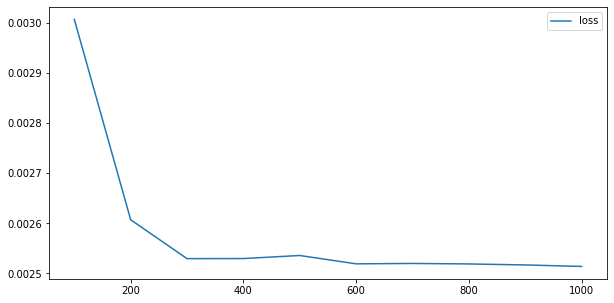

In [ ]:
all_losses = np.array(all_losses) / 100.0

fig, axs = plt.subplots(figsize = (10, 5))
plt.plot(all_epochs, all_losses, label = "loss")
#plt.plot(all_epochs, all_accuracy, label = "accuracy")
plt.legend()
plt.show()